# **Building a simple Segformer**

In this short notebook we'll show how to implement a simple Segformer (first in the real valued case) and then explain how we adapt it for a complex valued case as we need it for SAR imaging. Clearly, the part that matters most is the initial real valued Segformer explanation, for the rest, adapting in the complex case just comes down to using `torchcvnn` layers and for the most common ones resorting to native implementations (`Conv2d` with `dtype=torch.complex64`).

(np.float64(-0.5), np.float64(428.5), np.float64(511.5), np.float64(-0.5))

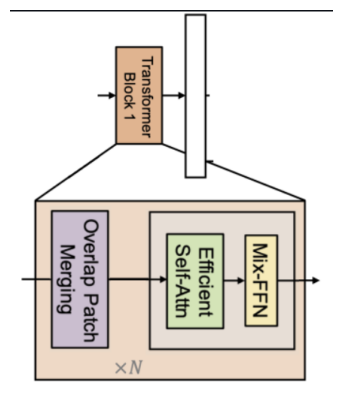

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

img1 = Image.open('./img/transformer_block.png')
fig, ax = plt.subplots(1, figsize=(5, 5))  
ax.imshow(img1)
ax.axis('off')

We here show this image to warn the reader, there is a kicker in the blueprint from the original paper, here is how thing should be implemented, see link [here](https://github.com/NVlabs/SegFormer/blob/9454025f0e74acbbc19c65cbbdf3ff8224997fe3/mmseg/models/backbones/mix_transformer.py#L318)

In [42]:
import torch
from einops import rearrange
from torch import nn
from torchvision.ops import StochasticDepth

from typing import List, Iterable


First given that in pytorch `nn.LayerNorm` only normalizes tensors following the last dimension of the input we have to overwrite it in a simple way

In [43]:

class LayerNorm2d(nn.LayerNorm):
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x

Then we implement the `OverlapPatchMerging` that basically does a 2d convolution but with a stride lesser that the kernel size ollowing it to reduce the input dimension, it is followed by our `LayerNorm2d`

In [44]:
class OverlapPatchMerging(nn.Sequential):
    def __init__(
            self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super().__init__(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=patch_size,
                stride=overlap_size,
                padding=patch_size // 2,
                bias=False
            ),
            LayerNorm2d(out_channels)
        )

Remember the dimensions for the output of a conv 2d layer : 
$$H_{out} = \lfloor \frac{H_{in} + 2*padding - kernel\_size}{stride} + 1 \rfloor$$
And same formula for width

Now is the time to introduce the `EfficientSelfAttention` module : in order to accelerate training and inference, one could get interested into reducing the O(N²) complexity of the attention mechanism (N = H*W) first let's dive into why this result holds: 

- Basically attention follows : Attention(Q, K, V) = softmax(QK^T / √d) · V
- Suppose a sequence of length N, Q, K and V have a [N, d] dimension (where d is the dimension of embeddings)
- QK^T produces a [N, N] matrix which yields the attention scores at the very heart of the attention mechanism but forces us to do a minimum of NxN multiplications 

An idea to reduce this compute time is to decrease the dimension of Q and K, to do so it is simple to flat H and W dimension and use a linear layer, here is what we will be doing : 

In [45]:
r = 4 # Is a reduction factor
channels = 8
x = torch.randn((1, channels, 64, 64))
_, _, h, w = x.shape

# Let's suppose we want to transform it in a tensor of shape [1, 8, 32, 32]
# nn.Linear does systematically apply on the last dim of tensor so :
x = rearrange(x, "b c h w -> b (h w) c") # [1, 64*64, 8]
x = rearrange(x, "b (hw r) c -> b hw (c r)", r=r) # [1, (64*64)/4, 8*4]

dim_reducer = nn.Linear(
    in_features=4*channels,
    out_features=channels
)

x = dim_reducer(x) # [1, (64*64)/4, 8]

# from x of shape [1, 1024, 8] after reducer
half_r = r // 2  # half_r = 2 (quand r = 4)
x = rearrange(x, "b (h w) c -> b c h w", h=h//half_r)  # [1, 8, 32, 32]
x.shape

torch.Size([1, 8, 32, 32])

Spatial size was reduced by `r=4`, so by 2 on each dimension (height and width) if you think about it a little longer, you understand that you could use a convolution layer with a `kernel_size=r` and a `stride=r` to achieve the same effect

Since the attention is equal to softmax(QK^T / √d) · V, we need to compute K and V using the reduced tensor otherwise, shapes won't match

In [46]:
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super().__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")
        x = rearrange(x, "b c h w -> b (h w) c")
        out = self.att(x, reduced_x, reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        return out

In [47]:
# Let's test it 
x = torch.randn((1, channels, 64, 64))
block = EfficientMultiHeadAttention(channels, reduction_ratio=r)
block(x).shape

torch.Size([1, 8, 64, 64])

The  reader may have noticed we are not using positional encoding, SegFormer uses a 3x3 depth-wise conv: the paper states that positional encoding is not necessary for semantic segmentation

The layer is composed by a dense layer --> 3x3 depth-wise conv --> GELU --> dense layer

In [48]:
class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super().__init__(
            # dense layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv (convolution is applied over channels)
            nn.Conv2d(
                channels,
                channels * expansion,
                kernel_size=3,
                groups=channels, # each input channel is dealt with separately meaning they're not "mixed"
                padding=1,
            ),
            nn.GELU(),
            # dense layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )


### nn.Conv2d Filter Matrix Explained

Let's take a quick dive one how `nn.Conv2d` works

**Without Groups (default, `groups=1`):**  
- **Input:** `(1, channels, H, W)`  
- **Layer:**
  `nn.Conv2d(channels, channels * expansion, kernel_size=3, padding=1)`
- **Weights Shape:** `(channels * expansion, channels, 3, 3)`  
- **Interpretation:** A filter matrix of shape `[channels, channels * expansion]`, where each filter uses all input channels.

**With Groups (`groups=channels`):**  
- **Layer:**
  `nn.Conv2d(channels, channels * expansion, kernel_size=3, padding=1, groups=channels)`
- **Weights Shape:** `(channels * expansion, 1, 3, 3)`  
- **Interpretation:** Each input channel is convolved separately with `expansion` filters → filter matrix of `[channels, expansion]`.


In [49]:
class ResidualAdd(nn.Module):
    """Just an util layer"""
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x


### SegFormerEncoderBlock Explained

The `SegFormerEncoderBlock` consists of two consecutive residual blocks. Each block applies a transformation to the input and adds the original input back (residual connection). This `ResidualAdd` layer does not appear directly in every transformers blocks of the model on the original blueprint, one should rather consider we use them quite similarly as in the paper `Attention Is All You Need`, it helps stabilize the gradient of the model and limits potential loss in information.

1. **First Residual Block:**
   - Applies `LayerNorm2d` and `EfficientMultiHeadAttention`.
   - Output:  
     
     $$y_1 = x + f_1(x)$$
     
     where \( f_1 \) is the attention operation.

2. **Second Residual Block:**
   - Applies `LayerNorm2d`, `MixMLP`, and `StochasticDepth` (this latter 'forgets' with a given prob the information that flowed through the whole block, it is highly helpful in regularization).
   - Input is \( y_1 \), output is:  
     
     $$y_2 = y_1 + f_2(y_1)$$
     
     where \( f_2 \) is the MLP path.

The block returns \( y_2 \), the result of two successive residual enhancements:

$$\text{Output} = x + f_1(x) + f_2(x + f_1(x))$$



In [50]:
class SegFormerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        channels: int,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
        drop_path_prob: float = .0
    ):
        super().__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")
                )
            ),
        )

In [51]:
x = torch.randn((1, channels, 64, 64))
block = SegFormerEncoderBlock(channels, reduction_ratio=r)
block(x).shape

torch.Size([1, 8, 64, 64])

The `SegformerEncoderStage` is nothing but the full implementation of a 'resolution' level of our Segformer Encoder, the Segformer analyses several scales of the image (that's precisely what makes its strength) meaning we can chose at each stage how many repetitions of attention layers (that's quite what the `SegformEncoderBlock` is about) but the scale of analysis is unique per each stage. 

Considering this, here is the subsequent implementation :

In [52]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super().__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

### **Encoder Explained**

The entire Encoder has one clear mission, process the data at different levels of resolution at each Encoder stage, memorize the output in a list and passing the current information at a given stage to the next one. For a better regularization we chose to create the `drop_probs` variable that is a list converted in an embedded list by our method chunk : that is to say a "list of lists", each of these associated to a stage such that within a stage the probability of a block to be "forgotten" increases linearly with the depth of the latter. It is quite intuitive, we consider it is less a problem to forget characteristics of a higher level in the encoder than primary ones. Apart from this, the Encoder just consists in stacking stages and memorizing their successive outputs in a list for the Upsampling part that comes in the Decoder.

In [53]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk
        
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int], # is the out_channel for every patch_merging of every stage in the encoder
        depths: List[int],
        all_num_heads: List[int], # is a parameter in the Pytorch attention layer
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super().__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths], # first stage will use in_channels the next ones will use widths[0], widths[1]... they are our resolution levels !
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )
        
    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features


In [54]:
x = torch.randn(2, 32, 128, 128)

in_channels = 32
widths = [64, 128, 256]
depths = [2, 3, 4]
all_num_heads = [1, 2, 4]
patch_sizes = [7, 3, 3]
overlap_sizes = [3, 3, 3]
reduction_ratios = [1, 1, 1]
mlp_expansions = [4, 4, 4]
drop_prob = 0.1

model = SegFormerEncoder(
    in_channels,
    widths,
    depths,
    all_num_heads,
    patch_sizes,
    overlap_sizes,
    reduction_ratios,
    mlp_expansions,
    drop_prob
)

features = model(x)

for i in range(min(len(features), 5)):
    print(features[i].shape)

torch.Size([2, 64, 43, 43])
torch.Size([2, 128, 15, 15])
torch.Size([2, 256, 5, 5])


Play with the parameters here and note the number of channels increases and the image size decreases, the model encodes in several levels of abstraction several scales from our image ! 

### **Decoder Explained**

The decoder is quite simple, it takes `F` features with sizes `batch, channels_i, height_i, width_i` and outputs `F'` features of the same spatial and channel size. The spatial size is fixed to `first_features_spatial_size / 4`. In our case, since our input is a 128x128 image, the output will be a 32x32 mask.

So a single SegFormerDecoderBlock contains one upsample layer (for the spatial dimension) and one conv layer (for the channels). The scale_factor parameter is needed to tell it how much we want to upsample the feature. 

(np.float64(-0.5), np.float64(500.5), np.float64(486.5), np.float64(-0.5))

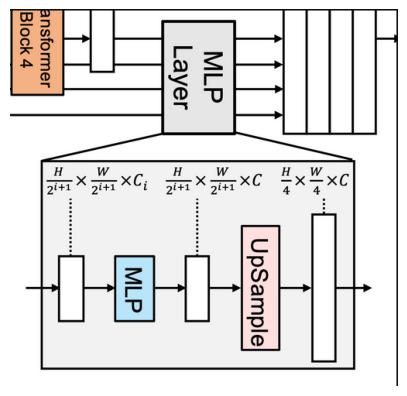

In [55]:
img2 = Image.open('./img/decoder_block.png')
fig, ax = plt.subplots(1, figsize=(5, 5))  
ax.imshow(img2)
ax.axis('off')

In [56]:
class SegFormerDecoderBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super().__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

One time again `DecoderBlock` 's output is memorized to be combined in the final segmentation head, which isn't part of the decoder.

In [57]:
class SegFormerDecoder(nn.Module):
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super().__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )
    
    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

### **Final step : Projection head**

The decoder's features are concatenated (they all have the same channels and spatial dimensions) on the channel axis. Then, they are passed to a segmentation head to reduce them from `channels * number` of features to `channels`. Finally, a dense layer outputs the final segmentation.

In [58]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super().__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(), # can try a different activation function
            nn.BatchNorm2d(channels) # can try with layer norm instead, see if there is a change in performance
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)
        x = self.fuse(x)
        x = self.predict(x)
        return x

### **The Final Segformer**

This is a quite straightforward assembling, however remember that the output number of channels must be the number of classes (in fact we'll infer the class of each pixel by using `F.softmax(dim=1)` meaning on the channel axis).

In [59]:
class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super().__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])
        segmentation = self.head(features)
        return segmentation

In [60]:
model = SegFormer(
        in_channels=4,  
        widths=[8, 16, 32, 64],
        depths=[3, 4, 6, 3],
        all_num_heads=[1, 2, 4, 8],
        patch_sizes=[7, 3, 3, 3],
        overlap_sizes=[4, 2, 2, 2],
        reduction_ratios=[8, 4, 2, 1],
        mlp_expansions=[4, 4, 4, 4],
        decoder_channels=64,
        scale_factors=[8, 4, 2, 1],
        num_classes=7,  
    )
    
input_tensor = torch.randn((64, 4, 128, 128))
    
output = model(input_tensor)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([64, 7, 32, 32])
